# Imports

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time

# Extract exemple data

In [2]:
import zipfile

path_to_zip_file = "../data/exemple_data/exemple_data.zip"
directory_to_extract_to = "../data/exemple_data/"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)


# Parameters

In [3]:
# date at which simulation is started, and simulation length (duration)
date_start = datetime.date(2021,4,1)
duration = 200

# path of gridded rainfall datasets
TAMSAT_path = "../data/exemple_data/TAMSAT_v3.1_burkina_rfe_filled/"
# CHIRPS_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/CHIRPS_v2.0_Africa_burkina"

# path for gridded weather datasets
AgERA5_data_path = "../data/exemple_data/AgERA5_burkina/"

# parameter file names
file_paramVariete = "USA_iowa_V42.yaml"
file_paramITK = "USA_iowa_V42.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# data exported from SARRA-H, only used for comparison purposes
file_df_weather = "Meteorologie_US0001.txt"
file_df_rain = "Pluviometrie_US0001.txt"
file_df_ET0 = "ET0_US0001.txt"
file_df_irrig = "Irrigation_AG3US20124.txt"

# Loading base data

This is data that won't change whatever the simulation.

In [4]:
# define grid dimensions from the rainfall dataset
grid_width, grid_height = get_grid_size(TAMSAT_path, date_start, duration)

# initialize empty xarray dataset
data = xr.Dataset()

# load rainfall and weather data
data = load_TAMSAT_data(data, TAMSAT_path, date_start, duration)
data = load_AgERA5_data(data, AgERA5_data_path, date_start, duration)

# compute day length raster
data = calc_day_length_raster(data, date_start, duration)

# load soil parameters
data = load_iSDA_soil_data(data, grid_width, grid_height)

100%|██████████| 200/200 [00:12<00:00, 16.09it/s]


# Load simulation data

Loading and preparing simulation-specific data
Loading main input dataarrays

In [5]:
# load variety, cropping system and soil parameters
paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

# initialize null irrigation scheme
data = initialize_default_irrigation(data)

In [6]:
data

<xarray.Dataset>
Dimensions:        (x: 239, y: 186, time: 200)
Coordinates:
  * x              (x) float64 -5.963 -5.925 -5.888 -5.85 ... 2.887 2.925 2.962
  * y              (y) float64 15.97 15.94 15.9 15.86 ... 9.15 9.113 9.075 9.038
    spatial_ref    int64 0
Dimensions without coordinates: time
Data variables: (12/14)
    rain           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 15.1 16.6 16.1 16.0
    tpMoy          (time, y, x) float32 nan nan nan nan ... 25.58 25.58 25.47
    ET0            (time, y, x) float32 nan nan nan nan ... 2.703 2.703 2.584
    rg             (time, y, x) float32 nan nan nan nan ... 20.0 20.0 20.0 19.39
    dureeDuJour    (time, y, x) float64 12.29 12.29 12.29 ... 11.9 11.9 11.9
    soil_type      (y, x) float64 11.0 11.0 9.0 9.0 11.0 ... 9.0 9.0 9.0 9.0 9.0
    ...             ...
    stockIniProf   (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    stockIniSurf   (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    seuilRuiss     (y, x) float64 20.0 20.0 18.0 18.0 ... 18.0 18.0 18.0 18.0
    pourcRuiss     (y, x) float64 0.27 0.27 0.32 0.32 ... 0.32 0.32 0.32 0.32
    ru             (y, x) float64 130.0 130.0 155.0 155.0 ... 155.0 155.0 155.0
    irrigation     (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

# Run

In [7]:
data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)

start_time = time.time()
data = run_model(paramVariete, paramITK, paramTypeSol, data, duration)
print("--- %s seconds, %s second per iter ---" % ((time.time() - start_time), (time.time() - start_time)/duration))

100%|██████████| 200/200 [02:03<00:00,  1.61it/s]

--- 123.86505198478699 seconds, 0.6193252623081207 second per iter ---


## Mapping results

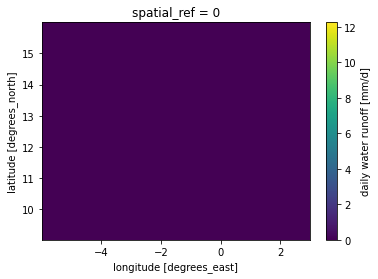

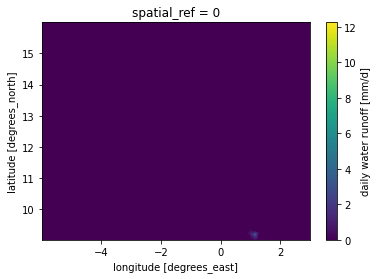

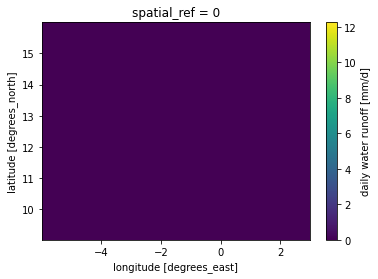

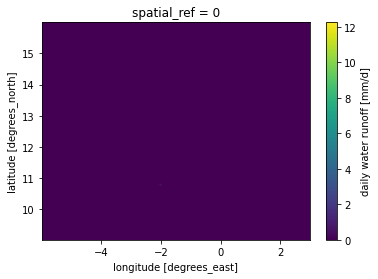

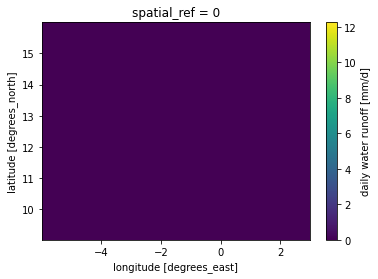

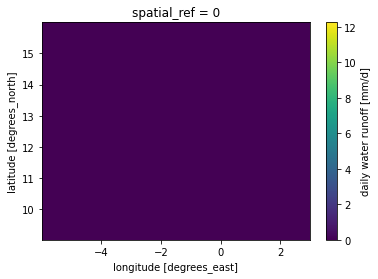

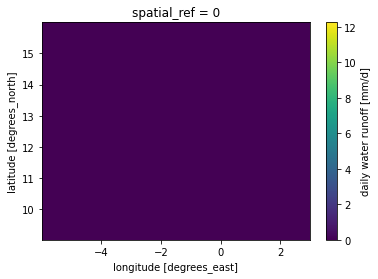

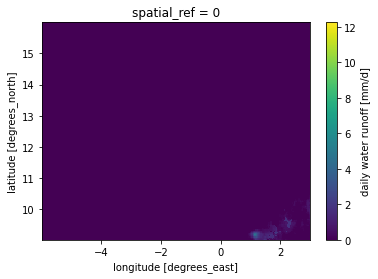

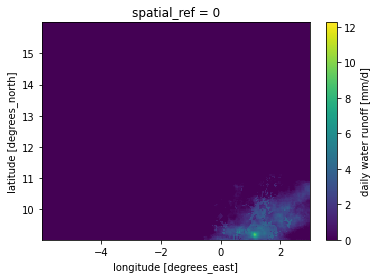

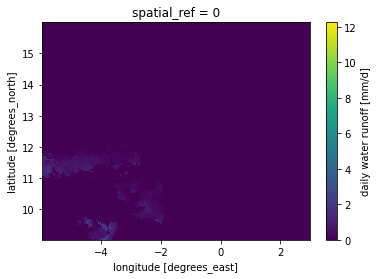

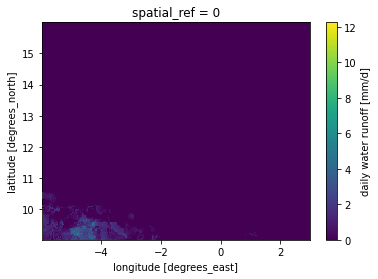

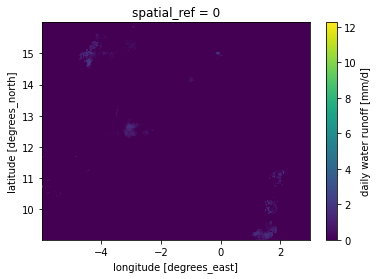

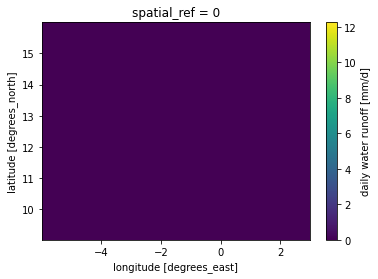

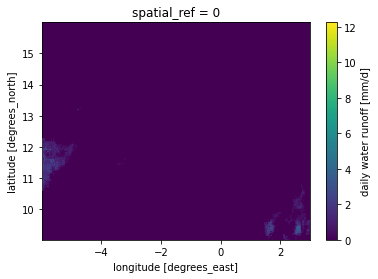

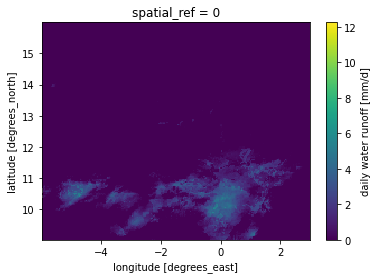

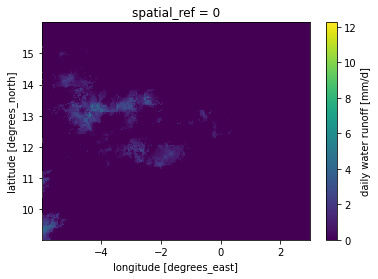

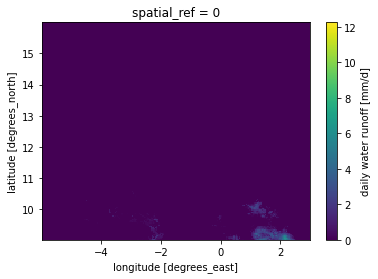

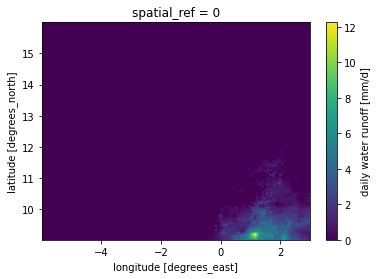

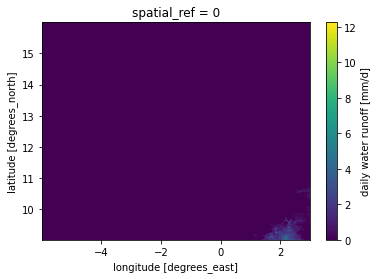

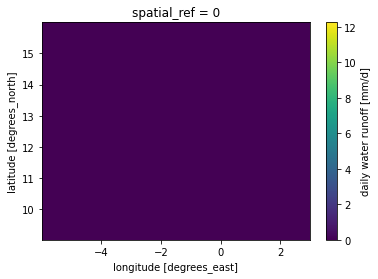

In [8]:
variable = "lr"
vmax = data[variable].max().values
for i in range(20):
    data[variable][9*i,:,:].plot(vmin=0, vmax=vmax)
    plt.show()

## Probing some values at given x,y coords

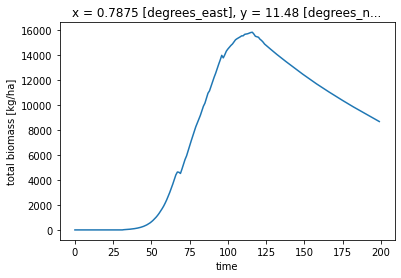

In [9]:
(data["biomasseTotale"])[:,120, 180].plot()

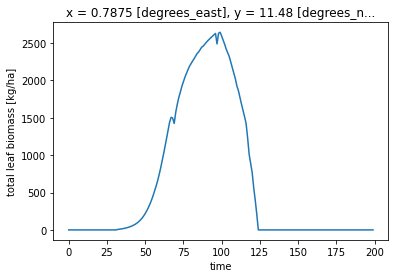

In [10]:
(data["biomasseFeuille"])[:,120, 180].plot()

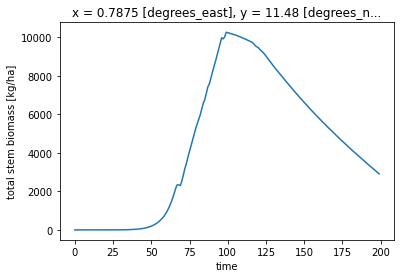

In [11]:
(data["biomasseTige"])[:,120, 180].plot()

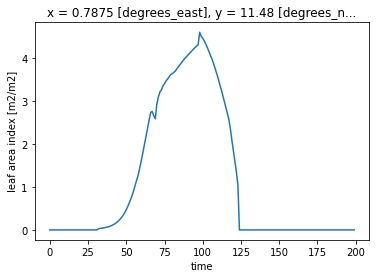

In [12]:
(data["lai"])[:,120, 180].plot()

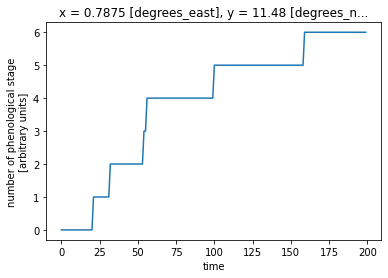

In [13]:
(data["numPhase"])[:,120, 180].plot()